In [1]:
import pandas as pd
import numpy as np
from utils.utils import *
from pymatgen.core import Composition
from utils.Featurizor import Featurizor
from sklearn.ensemble import VotingClassifier
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

# Splitting data into training and testing
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

config = {
    "mathtext.fontset": 'stix',
    "font.family": 'sans-serif',
    "font.sans-serif": ['Times New Roman'],
    "font.size": 24,
    'axes.unicode_minus': False
}
rcParams.update(config)
plt.rcParams['axes.unicode_minus'] = False
large = 22
med = 16
small = 12
params = {
    'axes.titlesize': large,
    'legend.fontsize': med,
    'figure.figsize': (8, 6),
    'axes.labelsize': med,
    'axes.titlesize': med,
    'xtick.labelsize': med,
    'ytick.labelsize': med,
    'figure.titlesize': large
}
plt.rcParams.update(params)
plt.rcParams['figure.dpi'] = 300
seed = 42

# init_data

In [2]:
data = pd.read_csv('init_data.csv',index_col=0).reset_index(drop=True)
test_data = pd.read_csv('test_data.csv',index_col=0).reset_index(drop=True)
data

,$Dp_b$,$F_b$,LUMO_character,$R_b$,$D_b$,$Nd_b$,$Ce_a$,LUMO_element,$Fi_b$,$(En)diff_{ab}$,$(En)diff_{cb}$,$o$,$y$
0,53.0,5,2,0.8647,7.29,10,1.510,8,708.6,0.65,1.48,0.617643,0
1,68.0,4,3,0.5900,7.44,5,1.113,25,717.3,0.62,1.89,0.421429,0
2,83.0,4,3,0.7100,7.15,5,2.810,24,652.9,0.15,0.92,0.385870,0
3,68.0,4,3,0.6500,7.44,5,1.510,25,717.3,0.24,1.89,0.464286,0
4,83.0,4,3,0.6200,7.15,5,1.840,24,652.9,0.66,0.92,0.336957,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,170.0,3,4,0.9200,8.23,0,1.510,65,565.8,0.11,1.38,0.500000,1
207,65.0,5,1,0.8000,7.31,10,0.670,49,558.3,0.22,1.66,0.571429,0
208,43.0,6,2,0.7600,6.69,10,1.510,51,834.0,0.74,1.39,0.542857,0
209,156.0,3,2,0.9000,8.80,0,1.510,16,581.0,0.08,1.35,0.489130,1


In [3]:
X_train = data.iloc[:,:-1]
y_train = data.iloc[:,-1]
X_test = test_data.iloc[:,:-1]
y_test = test_data.iloc[:,-1]

In [4]:
factor_train = pd.read_csv('factor_train.csv',index_col=0)
factor_test = pd.read_csv('factor_test.csv',index_col=0)
factor_train = factor_train.replace([np.inf, -np.inf], [1, 0])
factor_test = factor_test.replace([np.inf, -np.inf], [1, 0])

In [5]:
# add factor1
X_train = pd.concat([X_train.reset_index(drop=True),factor_train['0']],axis=1)
X_test = pd.concat([X_test.reset_index(drop=True),factor_test['0']],axis=1)

# unlabeled data

In [6]:
from CrabNet.kingcrab import CrabNet
from CrabNet.model import Model
from CrabNet.get_compute_device import get_compute_device
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

compute_device = get_compute_device()
model = Model(CrabNet(compute_device=compute_device).to(compute_device),
              model_name="", verbose=False, classification=False)

In [7]:
def get_unlabeled_data():
    def get_new_spinels(spinels_df):
        A = np.array(['Ag', 'Al', 'Ba', 'Be', 'Ca', 'Co', 'Cs', 'Cu', 'Fe', 'Ga', 'Ge', 'La', 'Mg', 'Mn', 'Mo', 'Ni'
                         , 'Rb', 'V', 'W', 'Zn'])
        B = np.array(['Ag', 'Al', 'Bi', 'Ca', 'Cd', 'Co', 'Cr', 'Cu', 'Fe', 'Ga', 'In', 'La', 'Lu',
                      'Mg', 'Mn', 'Mo', 'Na', 'Nd', 'Ni', 'Pd', 'Rb', 'Ti', 'V', 'W', 'Zn'])
        C = np.array(['O', 'S', 'Se'])
        formulee = spinels_df['formula'].values
        result = []
        for a in A:
            for b in B:
                for c in C:
                    if a != b:
                        formula = a + b + str(2) + c + str(4)
                        if Composition(formula).reduced_formula not in list(formulee):
                            result.append({"formula": formula, "A": a, "B": b, "C": c})
        return pd.DataFrame(result)
    
    def screen_Ef(spinels_df):
        model.load_network('./models/trained_models/eform.pth')
        new_data = spinels_df.copy()
        new_data['target'] = 0
        model.load_data(new_data)
        pred = model.predict(model.data_loader)[1]
        pred = np.nan_to_num(pred, copy=True, nan=0.0)
        new_data['Ef'] = pred
        result = new_data[new_data['Ef'] <= 0].reset_index(drop=True)
        print('origin length:%s' % len(new_data))
        print('after Ef screen:%s' % len(result))
        return result
    
    def screen_Eh(spinels_df):
        model.load_network('./models/trained_models/ehull.pth')
        model.load_data(spinels_df)
        pred = model.predict(model.data_loader)[1]
        pred = np.nan_to_num(pred, copy=True, nan=0.0)
        spinels_df['Eh'] = pred
        result = spinels_df[spinels_df['Eh'] <= 0.025].reset_index(drop=True)
        print('origin length:%s' % len(spinels_df))
        print('after Eh screen:%s' % len(result))
        return result
    
    def screen_non_metal(spinels_df):
        model = Model(CrabNet(compute_device=compute_device).to(compute_device),
                      model_name="", verbose=False, classification=True)
        model.load_network('./models/trained_models/is_metal.pth')
        spinels_df['classification_target'] = 0
        model.load_data(spinels_df)
        pred = model.predict(model.data_loader)[1]
        pred = np.nan_to_num(pred, copy=True, nan=0.0)
        spinels_df['is_metal'] = pred
        result = spinels_df[spinels_df['is_metal'] == 0].reset_index(drop=True)
        print('origin length:%s' % len(spinels_df))
        print('after non metal screen:%s' % len(result))
        return result
    
    spinels = pd.read_csv('./data/spinels_abc.csv', index_col=0)
    new_spinels = get_new_spinels(spinels)
    new_spinels = screen_Ef(new_spinels)
    new_spinels = screen_Eh(new_spinels)
    new_spinels = screen_non_metal(new_spinels)
    new_spinels = new_spinels.drop(columns=['classification_target', 'target', 'count'])
    print('origin length:%s' % len(new_spinels))
    new_spinels['$y$'] = 0
    new_spinels = Featurizor().featurize(new_spinels,is_structure=False,is_new_data=True)
    def get_f(data):
        f = data['$Ve_b$']-data['$F_b$']+data['$Ns_a$']-data['$Nd_b$']
        return f
    new_spinels['0'] = get_f(new_spinels)
    new_spinels_pool = new_spinels[X_train.columns]
    print('after electrically neutral screen:%s' % len(new_spinels))
    return new_spinels,new_spinels_pool

In [8]:
new_spinels,new_spinels_pool = get_unlabeled_data()

loading data with up to 3 elements in the formula
origin length:1293
after Ef screen:1293
loading data with up to 3 elements in the formula
origin length:1293
after Eh screen:780
loading data with up to 3 elements in the formula
origin length:780
after non metal screen:435
origin length:435


MultipleFeaturizer:   0%|          | 0/213 [00:00<?, ?it/s]

after electrically neutral screen:213


In [9]:
new_spinels_pool

,$Dp_b$,$F_b$,LUMO_character,$R_b$,$D_b$,$Nd_b$,$Ce_a$,LUMO_element,$Fi_b$,$(En)diff_{ab}$,$(En)diff_{cb}$,$o$,0
0,55.0,4,2,0.84500,10.50,10,3.39,34,731.0,0.32,0.62,0.426768,-1
1,215.0,3,2,1.14295,6.15,1,3.39,16,538.1,0.51,1.48,0.621168,1
2,215.0,3,2,1.14295,6.15,1,3.39,34,538.1,0.51,1.45,0.577247,1
3,137.0,3,2,0.94225,9.84,1,3.39,16,523.5,0.34,1.31,0.512092,1
4,137.0,3,2,0.94225,9.84,1,3.39,34,523.5,0.34,1.28,0.475884,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,50.0,5,2,0.62000,5.91,0,1.35,34,578.8,0.16,0.74,0.313131,0
209,137.0,3,1,0.86000,9.84,1,1.35,30,523.5,0.38,1.31,0.467391,1
210,137.0,3,1,0.86000,9.84,1,1.35,30,523.5,0.38,1.28,0.434343,1
211,87.0,4,3,0.69000,10.20,5,1.35,42,684.3,0.51,0.39,0.348485,-1


In [10]:
# new_spinels['pred_f'] = new_spinels['f'].map(lambda x: 1 if x>0 else 0)
unlabeled_data = new_spinels.iloc[:,2:]
unlabeled_data['formula'] = new_spinels['formula']
unlabeled_data

,$V_c$,$R_c$,$V_a$,$R_a$,$V_b$,$R_b$,$D_a$,$D_b$,$D_c$,$Ce_a$,$Ce_b$,$Ce_c$,$Dp_a$,$Dp_b$,$Dp_c$,$Fi_a$,$Fi_b$,$Fi_c$,$Ve_a$,$Ve_b$,$Ve_c$,$N_a$,$N_b$,$N_c$,$P_a$,$P_b$,$P_c$,$F_a$,$F_b$,$F_c$,...,$Mn_a$,$Mn_b$,$Mn_c$,$Ar_a$,$Ar_b$,$Ar_c$,$Cr_a$,$Cr_b$,$Cr_c$,$GEn_a$,$GEn_b$,$GEn_c$,$AEn_a$,$AEn_b$,$AEn_c$,$(En)diff_{ab}$,$(En)diff_{cb}$,$(En)diff_{ca}$,$tf$,$t$,$o$,HOMO_character,HOMO_element,HOMO_energy,LUMO_character,LUMO_element,LUMO_energy,gap_AO,0,formula
0,-2,1.98,3,0.39,2.5,0.84500,2.70,10.50,4.81000,3.39,2.95,2.46,57.80,55.0,28.9,577.5,731.0,941.0,3,11,6,13,47,34,3,5,4,5,4,7,...,73,65,89,1.25,1.60,1.15,1.18,1.34,1.16,3.5237,3.8522,5.7610,1.613,1.870,2.434,0.32,0.62,0.94,1.032288,0.196970,0.426768,2,34,-0.245806,2,34,-0.245806,0.000000,-1,AlAg2Se4
1,-2,1.84,3,0.39,2.5,1.14295,2.70,6.15,2.07000,3.39,4.47,2.85,57.80,215.0,19.4,577.5,538.1,999.6,3,3,6,13,57,16,3,6,3,5,3,7,...,73,13,88,1.25,1.95,1.00,1.18,1.69,1.02,3.5237,4.5168,5.8458,1.613,1.090,2.589,0.51,1.48,0.97,1.158435,0.211957,0.621168,2,16,-0.261676,2,16,-0.261676,0.000000,1,AlLa2S4
2,-2,1.98,3,0.39,2.5,1.14295,2.70,6.15,4.81000,3.39,4.47,2.46,57.80,215.0,28.9,577.5,538.1,941.0,3,3,6,13,57,34,3,6,4,5,3,7,...,73,13,89,1.25,1.95,1.15,1.18,1.69,1.16,3.5237,4.5168,5.7610,1.613,1.090,2.434,0.51,1.45,0.94,1.141162,0.196970,0.577247,2,34,-0.245806,2,34,-0.245806,0.000000,1,AlLa2Se4
3,-2,1.84,3,0.39,2.5,0.94225,2.70,9.84,2.07000,3.39,4.43,2.85,57.80,137.0,19.4,577.5,523.5,999.6,3,3,6,13,71,16,3,6,3,5,3,7,...,73,41,88,1.25,1.75,1.00,1.18,1.56,1.02,3.5237,6.1824,5.8458,1.613,1.090,2.589,0.34,1.31,0.97,1.080493,0.211957,0.512092,2,16,-0.261676,2,16,-0.261676,0.000000,1,AlLu2S4
4,-2,1.98,3,0.39,2.5,0.94225,2.70,9.84,4.81000,3.39,4.43,2.46,57.80,137.0,28.9,577.5,523.5,941.0,3,3,6,13,71,34,3,6,4,5,3,7,...,73,41,89,1.25,1.75,1.15,1.18,1.56,1.16,3.5237,6.1824,5.7610,1.613,1.090,2.434,0.34,1.28,0.94,1.067824,0.196970,0.475884,2,34,-0.245806,2,34,-0.245806,0.000000,1,AlLu2Se4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,-2,1.98,2,0.60,3.0,0.62000,7.13,5.91,4.81000,1.35,2.81,2.46,38.67,50.0,28.9,906.4,578.8,941.0,12,3,6,30,31,34,4,4,4,4,5,7,...,69,74,89,1.35,1.30,1.15,1.25,1.26,1.16,3.7515,4.1672,5.7610,1.590,1.756,2.434,0.16,0.74,0.90,0.872739,0.303030,0.313131,2,34,-0.245806,2,34,-0.245806,0.000000,0,ZnGa2Se4
209,-2,1.84,2,0.60,3.0,0.86000,7.13,9.84,2.07000,1.35,4.43,2.85,38.67,137.0,19.4,906.4,523.5,999.6,12,3,6,30,71,16,4,6,3,4,3,7,...,69,41,88,1.35,1.75,1.00,1.25,1.56,1.02,3.7515,6.1824,5.8458,1.590,1.090,2.589,0.38,1.31,0.93,0.958307,0.326087,0.467391,2,16,-0.261676,1,30,-0.222725,0.038951,1,ZnLu2S4
210,-2,1.98,2,0.60,3.0,0.86000,7.13,9.84,4.81000,1.35,4.43,2.46,38.67,137.0,28.9,906.4,523.5,941.0,12,3,6,30,71,34,4,6,4,4,3,7,...,69,41,89,1.35,1.75,1.15,1.25,1.56,1.16,3.7515,6.1824,5.7610,1.590,1.090,2.434,0.38,1.28,0.90,0.953299,0.303030,0.434343,2,34,-0.245806,1,30,-0.222725,0.023081,1,ZnLu2Se4
211,-2,1.98,2,0.60,3.0,0.69000,7.13,10.20,4.81000,1.35,6.82,2.46,38.67,87.0,28.9,906.4,684.3,941.0,12,6,6,30,42,34,4,5,4,4,4,7,...,69,50,89,1.35,1.45,1.15,1.25,1.30,1.16,3.7515,3.5548,5.7610,1.590,1.470,2.434,0.51,0.39,0.90,0.896236,0.303030,0.348485,3,42,-0.153347,3,42,-0.153347,0.000000,-1,ZnMo2Se4


In [11]:
spinels_dft = pd.read_csv('spinels_dft.csv')
spinels_dft['formula'] = spinels_dft['formula'].map(lambda x: Composition(x).reduced_formula)
new_spinels['formula'] = new_spinels['formula'].map(lambda x: Composition(x).reduced_formula)
new_spinels_pool = new_spinels_pool[new_spinels['formula'].isin(spinels_dft['formula'])].reset_index(drop=True)

In [12]:
new_spinels_pool

,$Dp_b$,$F_b$,LUMO_character,$R_b$,$D_b$,$Nd_b$,$Ce_a$,LUMO_element,$Fi_b$,$(En)diff_{ab}$,$(En)diff_{cb}$,$o$,0
0,215.0,3,2,1.14295,6.15,1,3.39,34,538.1,0.51,1.45,0.577247,1
1,137.0,3,2,0.94225,9.84,1,3.39,34,523.5,0.34,1.28,0.475884,1
2,50.0,5,1,0.62000,5.91,0,1.90,31,578.8,0.92,1.63,0.442857,0
3,137.0,3,1,0.86000,9.84,1,1.90,71,523.5,0.38,1.31,0.467391,1
4,137.0,3,1,0.86000,9.84,1,1.90,71,523.5,0.38,1.28,0.434343,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,319.8,1,3,1.52000,1.53,0,8.90,74,403.0,1.54,1.76,0.826087,2
87,319.8,1,3,1.52000,1.53,0,8.90,74,403.0,1.54,1.73,0.767677,2
88,137.0,3,1,0.86000,9.84,1,1.35,30,523.5,0.38,1.31,0.467391,1
89,137.0,3,1,0.86000,9.84,1,1.35,30,523.5,0.38,1.28,0.434343,1


In [13]:
spinels_labeled = pd.merge(spinels_dft,new_spinels,on='formula',how='inner')
spinels_labeled

,formula,is gap direct,pbe gap,$y$,$V_c$,$R_c$,$V_a$,$R_a$,$V_b$,$R_b$,$D_a$,$D_b$,$D_c$,$Ce_a$,$Ce_b$,$Ce_c$,$Dp_a$,$Dp_b$,$Dp_c$,$Fi_a$,$Fi_b$,$Fi_c$,$Ve_a$,$Ve_b$,$Ve_c$,$N_a$,$N_b$,$N_c$,$P_a$,$P_b$,...,$W_c$,$Mn_a$,$Mn_b$,$Mn_c$,$Ar_a$,$Ar_b$,$Ar_c$,$Cr_a$,$Cr_b$,$Cr_c$,$GEn_a$,$GEn_b$,$GEn_c$,$AEn_a$,$AEn_b$,$AEn_c$,$(En)diff_{ab}$,$(En)diff_{cb}$,$(En)diff_{ca}$,$tf$,$t$,$o$,HOMO_character,HOMO_element,HOMO_energy,LUMO_character,LUMO_element,LUMO_energy,gap_AO,0
0,La2AlSe4,1,0.0017,0,-2,1.98,3,0.3900,2.5,1.14295,2.70,6.15,4.81000,3.39,4.47,2.46,57.8,215.00,28.9,577.5,538.1,941.0,3,3,6,13,57,34,3,6,...,78.9600,73,13,89,1.25,1.95,1.15,1.18,1.69,1.16,3.5237,4.5168,5.7610,1.613,1.090,2.434,0.51,1.45,0.94,1.141162,0.196970,0.577247,2,34,-0.245806,2,34,-0.245806,0.000000,1
1,Lu2AlSe4,0,0.0012,0,-2,1.98,3,0.3900,2.5,0.94225,2.70,9.84,4.81000,3.39,4.43,2.46,57.8,137.00,28.9,577.5,523.5,941.0,3,3,6,13,71,34,3,6,...,78.9600,73,41,89,1.25,1.75,1.15,1.18,1.56,1.16,3.5237,6.1824,5.7610,1.613,1.090,2.434,0.34,1.28,0.94,1.067824,0.196970,0.475884,2,34,-0.245806,2,34,-0.245806,0.000000,1
2,Ba(GaO2)2,1,1.4392,0,-2,1.40,2,1.2398,3.0,0.62000,3.59,5.91,0.00143,1.90,2.81,2.62,272.0,50.00,5.3,502.9,578.8,1313.9,2,3,6,56,31,8,6,4,...,15.9994,9,74,87,2.15,1.30,0.60,1.98,1.26,0.73,4.4699,4.1672,8.3703,0.881,1.756,3.610,0.92,1.63,2.55,0.662691,0.885571,0.442857,2,8,-0.338381,1,31,-0.328019,0.010362,0
3,Ba(LuS2)2,1,2.4229,0,-2,1.84,2,1.2398,3.0,0.86000,3.59,9.84,2.07000,1.90,4.43,2.85,272.0,137.00,19.4,502.9,523.5,999.6,2,3,6,56,71,16,6,6,...,32.0660,9,41,88,2.15,1.75,1.00,1.98,1.56,1.02,4.4699,6.1824,5.8458,0.881,1.090,2.589,0.38,1.31,1.69,0.759227,0.673804,0.467391,2,16,-0.261676,1,71,-0.155112,0.106564,1
4,Ba(LuSe2)2,0,0.0012,0,-2,1.98,2,1.2398,3.0,0.86000,3.59,9.84,4.81000,1.90,4.43,2.46,272.0,137.00,28.9,502.9,523.5,941.0,2,3,6,56,71,34,6,6,...,78.9600,9,41,89,2.15,1.75,1.15,1.98,1.56,1.16,4.4699,6.1824,5.7610,0.881,1.090,2.434,0.38,1.28,1.66,0.763871,0.626162,0.434343,2,34,-0.245806,1,71,-0.155112,0.090694,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,Ge(MoO2)2,0,0.0056,0,-2,1.40,2,0.5421,3.0,0.69000,5.32,10.20,0.00143,3.85,6.82,2.62,40.0,87.00,5.3,762.0,684.3,1313.9,4,6,6,32,42,8,4,5,...,15.9994,79,50,87,1.25,1.45,0.60,1.22,1.30,0.73,4.6406,3.5548,8.3703,1.994,1.470,3.610,0.15,1.28,1.43,0.931977,0.387214,0.492857,3,42,-0.153347,3,42,-0.153347,0.000000,-1
87,Nd2GeS4,0,0.0004,0,-2,1.84,2,0.5421,3.0,0.98000,5.32,7.01,2.07000,3.85,3.40,2.85,40.0,208.00,19.4,762.0,533.1,999.6,4,3,6,32,60,16,4,6,...,32.0660,79,19,88,1.25,1.85,1.00,1.22,1.84,1.02,4.6406,4.7152,5.8458,1.994,1.090,2.589,0.87,1.44,0.57,1.025226,0.294620,0.532609,4,60,-0.179508,4,60,-0.179508,0.000000,2
88,Nd2GeSe4,0,0.1828,0,-2,1.98,2,0.5421,3.0,0.98000,5.32,7.01,4.81000,3.85,3.40,2.46,40.0,208.00,28.9,762.0,533.1,941.0,4,3,6,32,60,34,4,6,...,78.9600,79,19,89,1.25,1.85,1.15,1.22,1.84,1.16,4.6406,4.7152,5.7610,1.994,1.090,2.434,0.87,1.41,0.54,1.016389,0.273788,0.494949,4,60,-0.179508,4,60,-0.179508,0.000000,2
89,Ge(PdO2)2,0,0.0006,0,-2,1.40,2,0.5421,3.0,0.76000,5.32,12.00,0.00143,3.85,3.89,2.62,40.0,26.14,5.3,762.0,804.4,1313.9,4,10,6,32,46,8,4,5,...,15.9994,79,62,87,1.25,1.40,0.60,1.22,1.28,0.73,4.6406,3.7880,8.3703,1.994,1.590,3.610,0.19,1.24,1.43,0.963192,0.387214,0.542857,3,46,-0.160771,3,46,-0.160771,0.000000,-2


In [14]:
X_pool = new_spinels_pool.values
y_pool = spinels_labeled['is gap direct'].values
formula_pool = spinels_labeled['formula'].values

# active learn

In [15]:
from joblib import load

voting_clf = load('./models/voting.joblib')

rf = load('./models/rf.joblib')
lgbm = load('./models/lgbm.joblib')
ext = load('./models/ext.joblib')
lr = load('./models/lr.joblib')
xb = load('./models/xb.joblib')
cb = load('./models/cb.joblib')
gb = load('./models/gb.joblib')

In [16]:
names = [
            "Random Forest",
            'LGBM',
            "Logistic Regression",
            "ExtraTrees",
            "XGBoost",
            "GradientBoost",
            "CatBoost"
        ]
classifiers = [
            rf,
            lgbm,
            lr,
            ext,
            xb,
            gb,
            cb
        ]

In [17]:
for model,name in zip(classifiers+[voting_clf],names+['Voting']):
    model.fit(X_train.values,y_train.values)
    y_pred = model.predict(X_test.values)
    print(name,0.5*accuracy_score(y_test,y_pred)+0.5*f1_score(y_test,y_pred))

Random Forest 0.7637237762237763
LGBM 0.8007659713168187
Logistic Regression 0.6153846153846154
ExtraTrees 0.7108974358974359
XGBoost 0.7802197802197802
GradientBoost 0.7851458885941645
CatBoost 0.7210723598435463
Voting 0.812002652519894


# Default model

In [18]:
from modAL.models import ActiveLearner, Committee
learner_list = list()
classifiers = [
            lgbm,
            xb,
            gb,
            voting_clf
        ]
for model in classifiers+[voting_clf]:
      # initializing learner
    learner = ActiveLearner(
        estimator=model,
        X_training=X_train.values, y_training=y_train.values
    )
    learner_list.append(learner)
# assembling the committee
committee = Committee(learner_list=learner_list)

In [19]:
def binary_performances(y_true, y_prob, thresh=0.5, labels=['Direct','Indirect']):
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, auc, roc_curve
    
    shape = y_prob.shape
    if len(shape) > 1:
        if shape[1] > 2:
            raise ValueError('A binary class problem is required')
        else:
            y_prob = y_prob[:,1]
    
    plt.figure(figsize=[15,4])
    
    #1 -- Confusion matrix
    cm = confusion_matrix(y_true, (y_prob>thresh).astype(int))
    
    plt.subplot(131)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, 
                     annot_kws={"size": 14}, fmt='g')
    cmlabels = ['TN', 'FP',
               'FN', 'TP']
    for i,t in enumerate(ax.texts):
        t.set_text(t.get_text() + "\n" + cmlabels[i])
    plt.title('Confusion Matrix', size=15)
    plt.xlabel('Predicted Values', size=13)
    plt.ylabel('True Values', size=13)
      
    #2 -- Distributions of Predicted Probabilities of both classes
    plt.subplot(132)
    plt.hist(y_prob[y_true==1], density=True, bins=25,
             alpha=.5, color='green',  label=labels[0])
    plt.hist(y_prob[y_true==0], density=True, bins=25,
             alpha=.5, color='red', label=labels[1])
    plt.axvline(thresh, color='blue', linestyle='--', label='Boundary')
    plt.xlim([0,1])
    plt.title('Distributions of Predictions', size=15)
    plt.xlabel('Positive Probability (predicted)', size=13)
    plt.ylabel('Samples (normalized scale)', size=13)
    plt.legend(loc="upper right")
    
    #3 -- ROC curve with annotated decision point
    fp_rates, tp_rates, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fp_rates, tp_rates)
    plt.subplot(133)
    plt.plot(fp_rates, tp_rates, color='orange',
             lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')
    tn, fp, fn, tp = [i for i in cm.ravel()]
    plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.title('ROC Curve', size=15)
    plt.legend(loc="lower right")
    plt.subplots_adjust(wspace=.3)
    plt.show()

    tn, fp, fn, tp = [i for i in cm.ravel()]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2*(precision * recall) / (precision + recall)
    results = {
        "Precision": precision, "Recall": recall,
        "F1 Score": F1, "AUC": roc_auc
    }
    
    prints = [f"{kpi}: {round(score, 3)}" for kpi,score in results.items()]
    prints = ' | '.join(prints)
    print(prints)
    
    return results

In [20]:
from sklearn.metrics import *
y_pred = committee.predict(X_test.values)
unqueried_score = 0.5*accuracy_score(y_test,y_pred)+0.5*f1_score(y_test,y_pred)
# unqueried_score = accuracy_score(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90        71
           1       0.88      0.64      0.74        33

    accuracy                           0.86       104
   macro avg       0.86      0.80      0.82       104
weighted avg       0.86      0.86      0.85       104



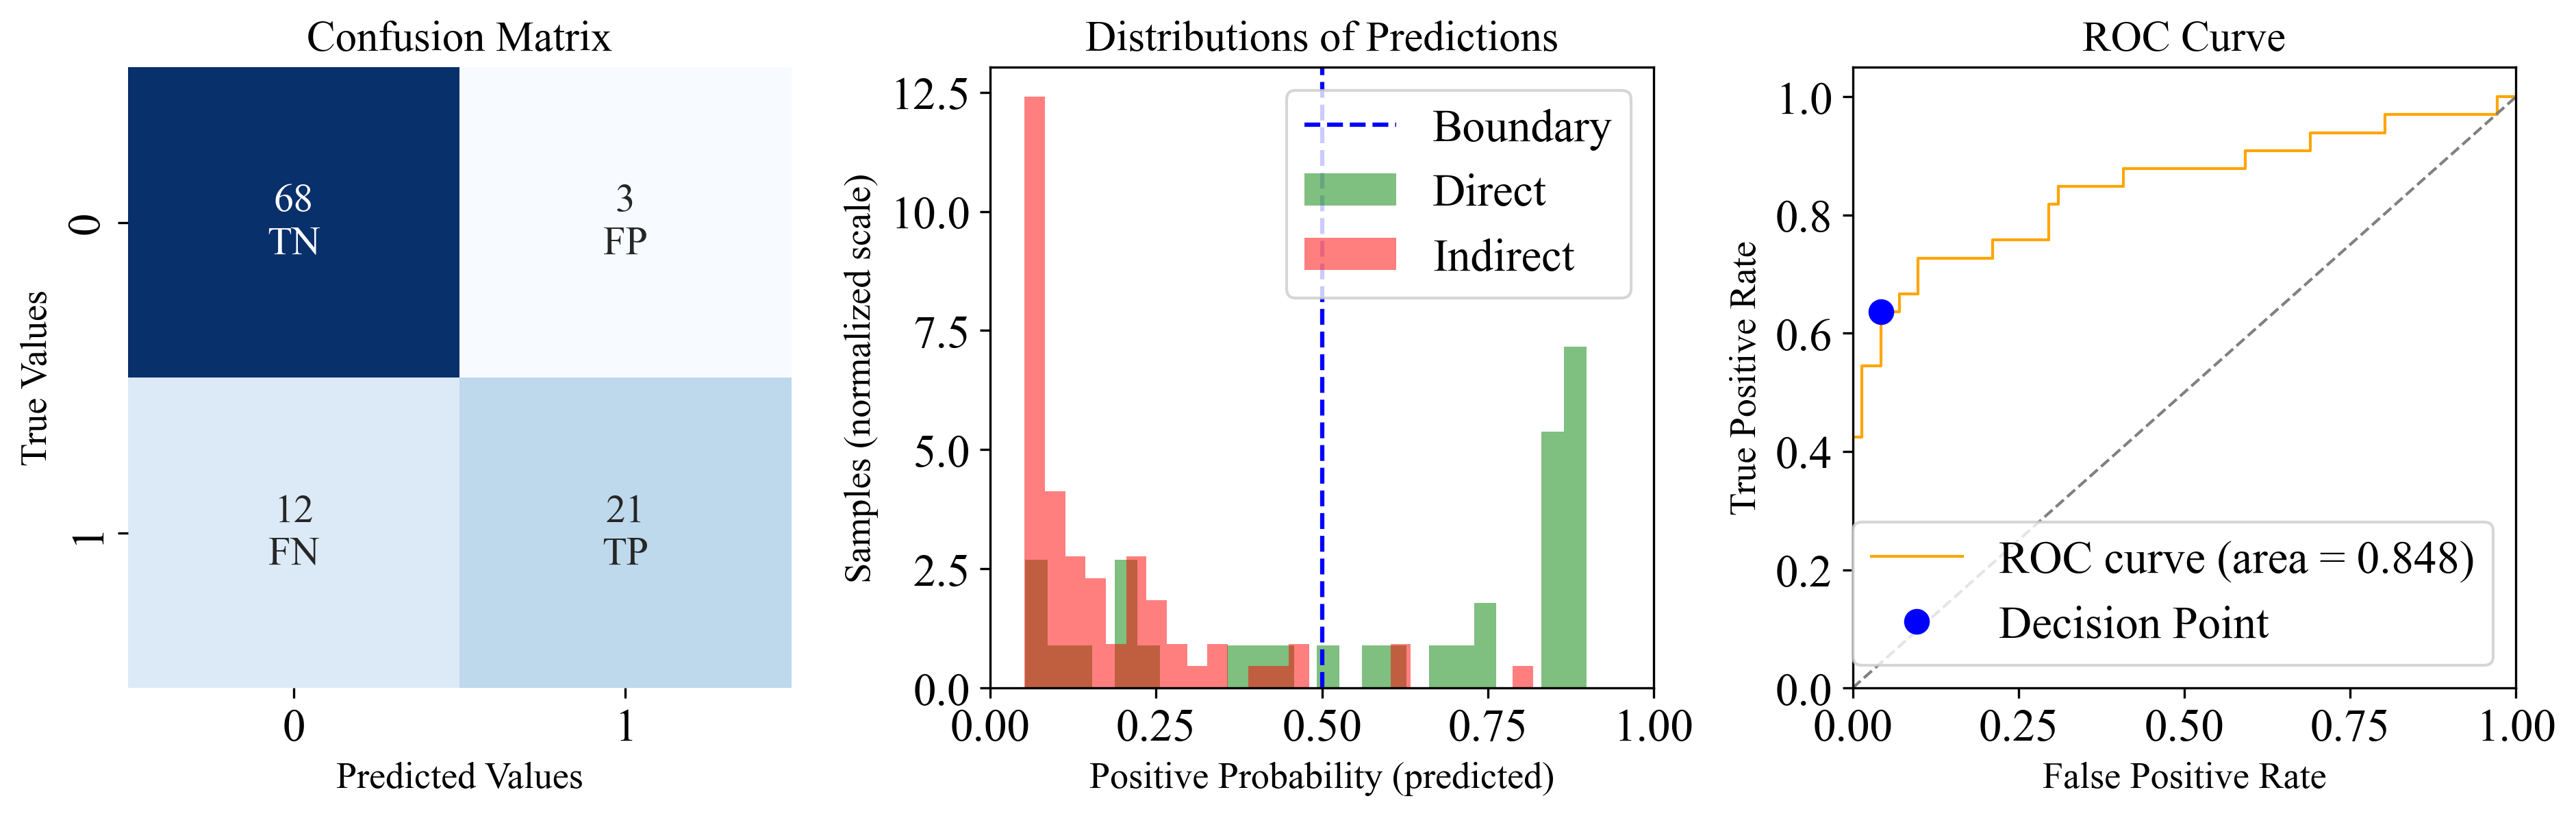

Precision: 0.875 | Recall: 0.636 | F1 Score: 0.737 | AUC: 0.848
0.8557692307692307 0.7368421052631579
0.7963056680161943


In [21]:
y_prob = committee.predict_proba(X_test.values)
binary_performances(y_test,y_prob)
print(accuracy_score(y_test,y_pred),f1_score(y_test,y_pred))
print(0.5*accuracy_score(y_test,y_pred)+0.5*f1_score(y_test,y_pred))

In [22]:
import copy
from tqdm import tqdm
performance_history = [unqueried_score]
# query by committee
n_queries = 91
best = 0
model = None
result1 = []
for idx in tqdm(range(n_queries)):
    query_idx, query_instance = committee.query(X_pool)
    committee.teach(
        X=X_pool[query_idx],
        y=y_pool[query_idx]
    )
    formula = formula_pool[query_idx][0]
    y_pred = committee.predict(X_test.values)
    score = 0.5*accuracy_score(y_test,y_pred)+0.5*f1_score(y_test,y_pred)
    if best <= score:
        best = score
        model = copy.deepcopy(committee)
        print(best,score)
#     score = accuracy_score(y_test,y_pred)
    result1.append({'data':formula,'score':score})
    performance_history.append(score)
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)
    formula_pool = np.delete(formula_pool, query_idx)

  1%|          | 1/91 [00:04<06:53,  4.60s/it]

0.7963056680161943 0.7963056680161943


 21%|██        | 19/91 [01:27<05:40,  4.73s/it]

0.7963056680161943 0.7963056680161943



 22%|██▏       | 20/91 [01:32<05:30,  4.65s/it]

0.7963056680161943 0.7963056680161943


 26%|██▋       | 24/91 [01:50<05:12,  4.67s/it]

0.8076923076923077 0.8076923076923077


100%|██████████| 91/91 [07:04<00:00,  4.67s/it]


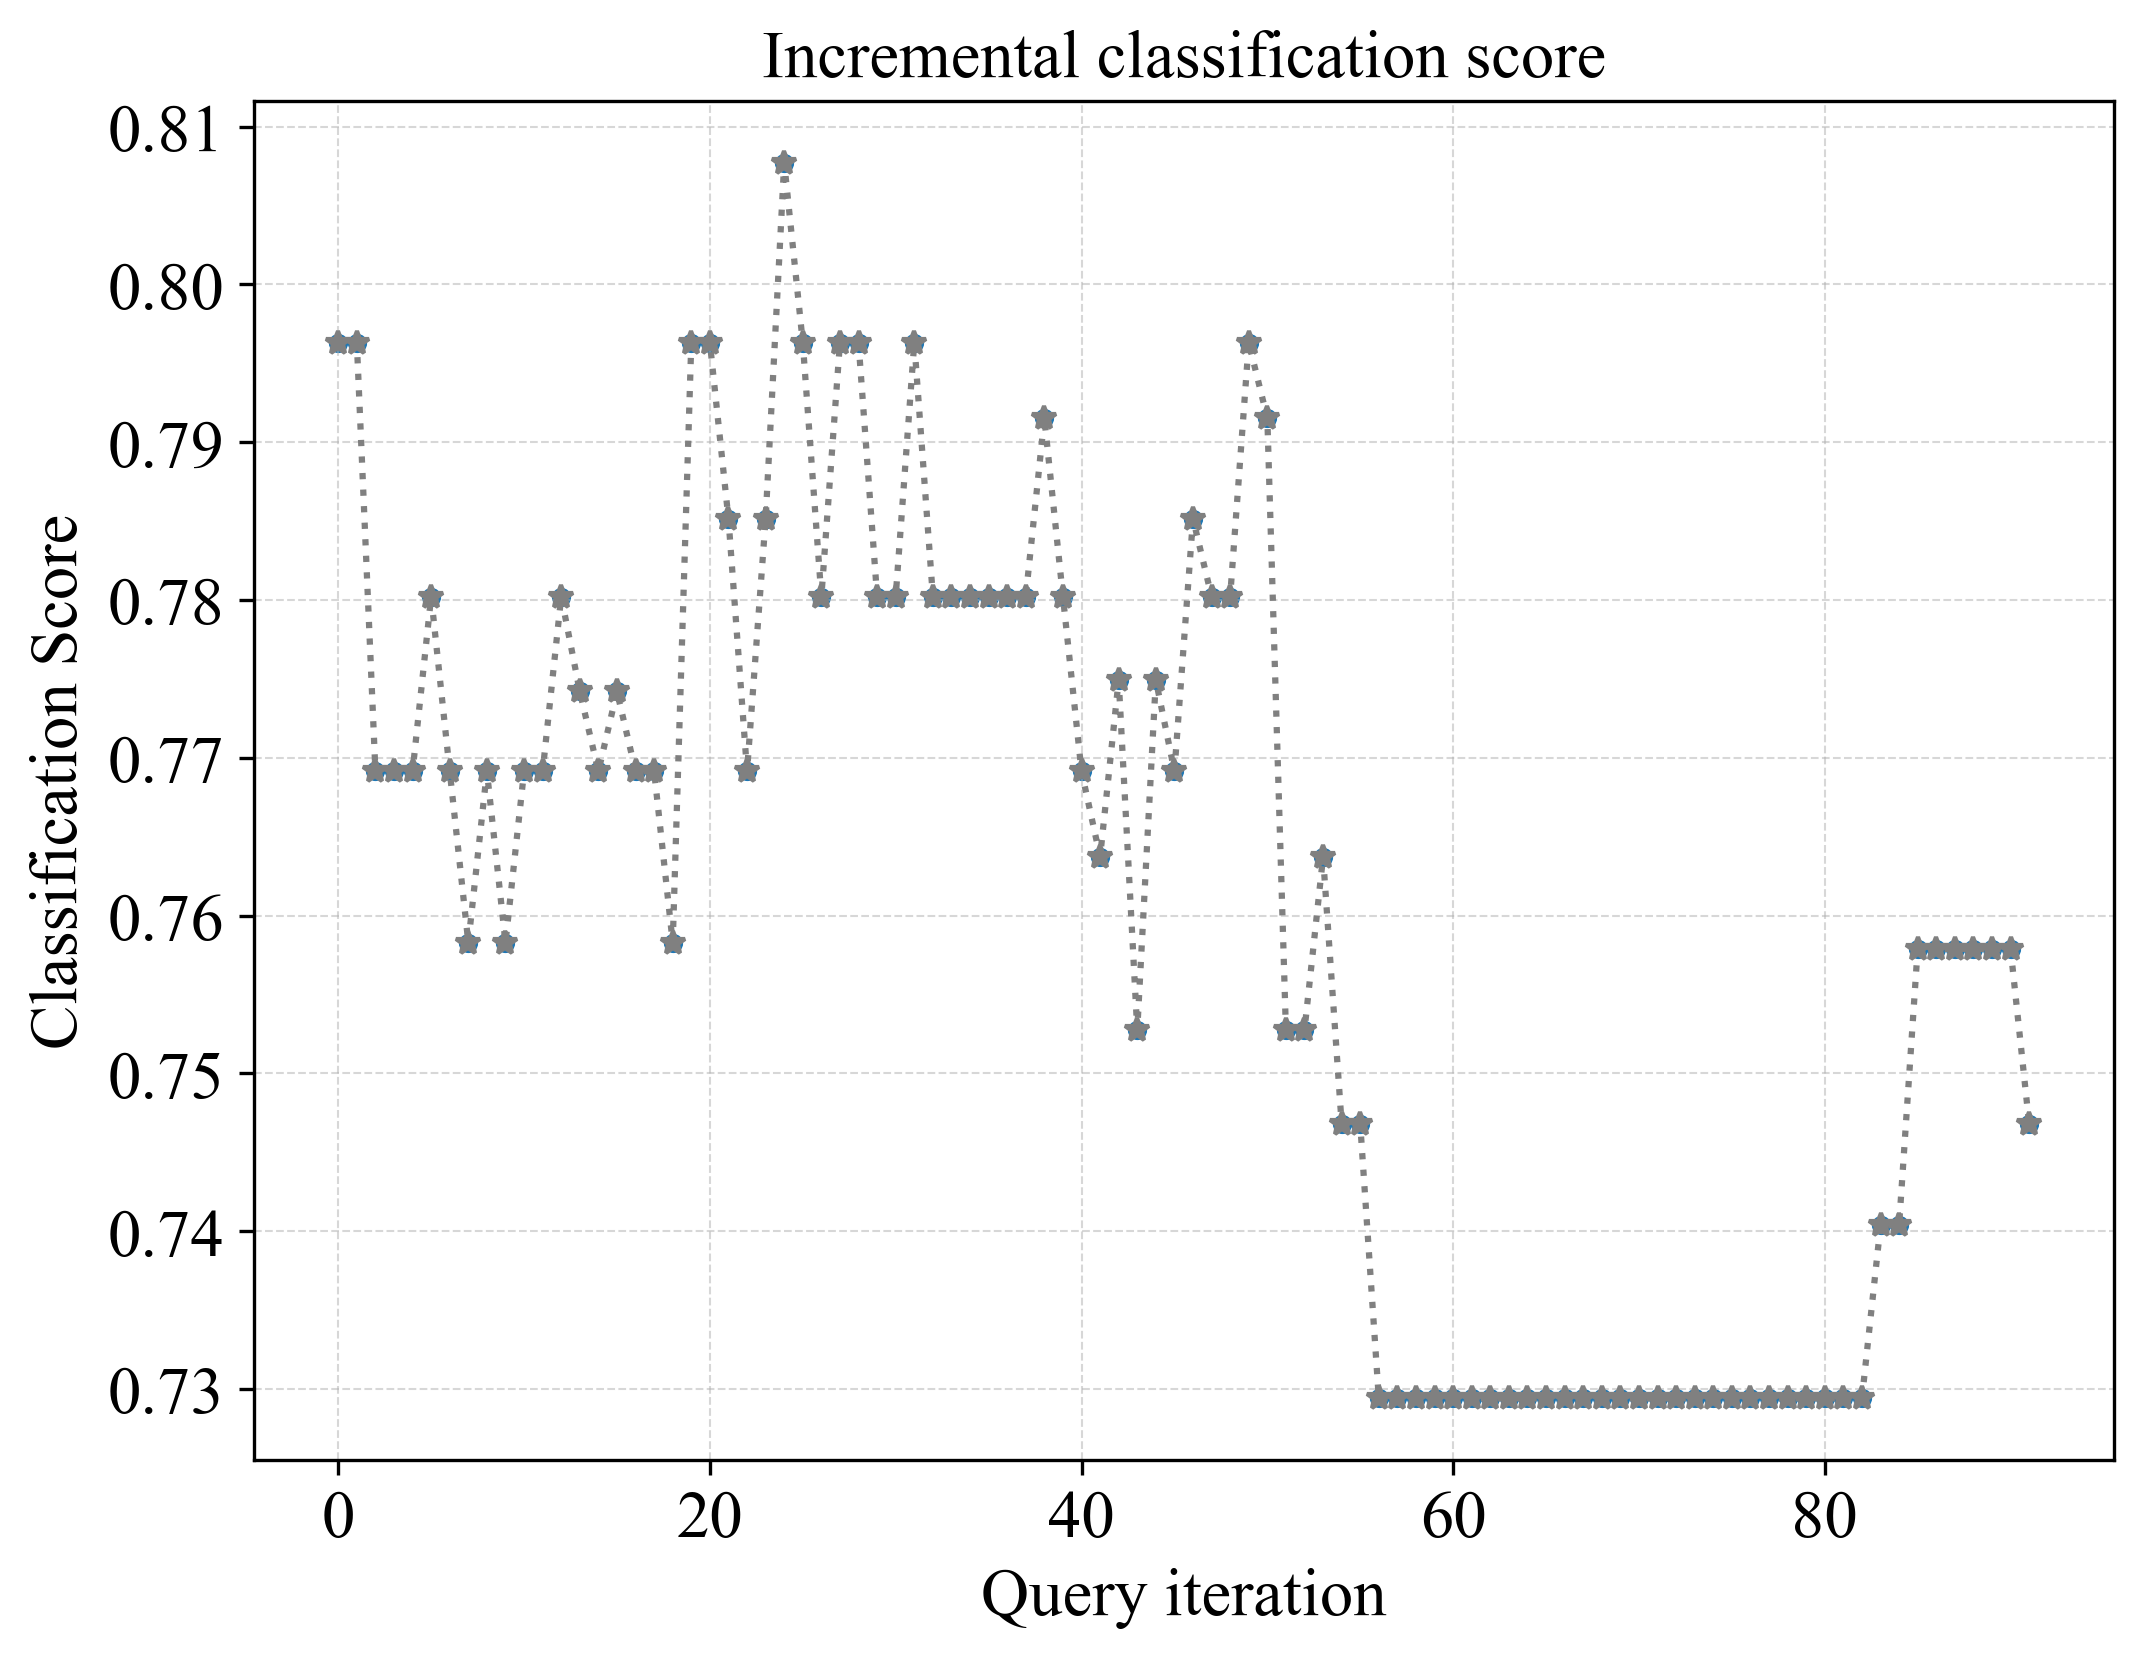

In [23]:
import matplotlib as mpl
# Plot our performance over time.
fig, ax = plt.subplots()

ax.plot(performance_history,':',marker='*',color='grey')
ax.scatter(range(len(performance_history)), performance_history, s=13)

# ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
# ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
# ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax.set_title('Incremental classification score')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Score')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()

In [24]:
result = pd.DataFrame(result1)
result

,data,score
0,Ba(NdS2)2,0.796306
1,Ba(GaO2)2,0.769146
2,Cd2MoO4,0.769146
3,Rb2MoO4,0.769146
4,Mn(WSe2)2,0.780220
...,...,...
86,La2GeO4,0.757892
87,Mg2GeS4,0.757892
88,Mg2GeSe4,0.757892
89,Ge(MoO2)2,0.757892


In [25]:
y_pred = model.predict(X_test.values)
accuracy_score(y_test,y_pred),f1_score(y_test,y_pred)

(0.8653846153846154, 0.75)

In [26]:
y_pred = model.predict(X_test.values)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91        71
           1       0.91      0.64      0.75        33

    accuracy                           0.87       104
   macro avg       0.88      0.80      0.83       104
weighted avg       0.87      0.87      0.86       104



0.8653846153846154 0.75
0.8076923076923077


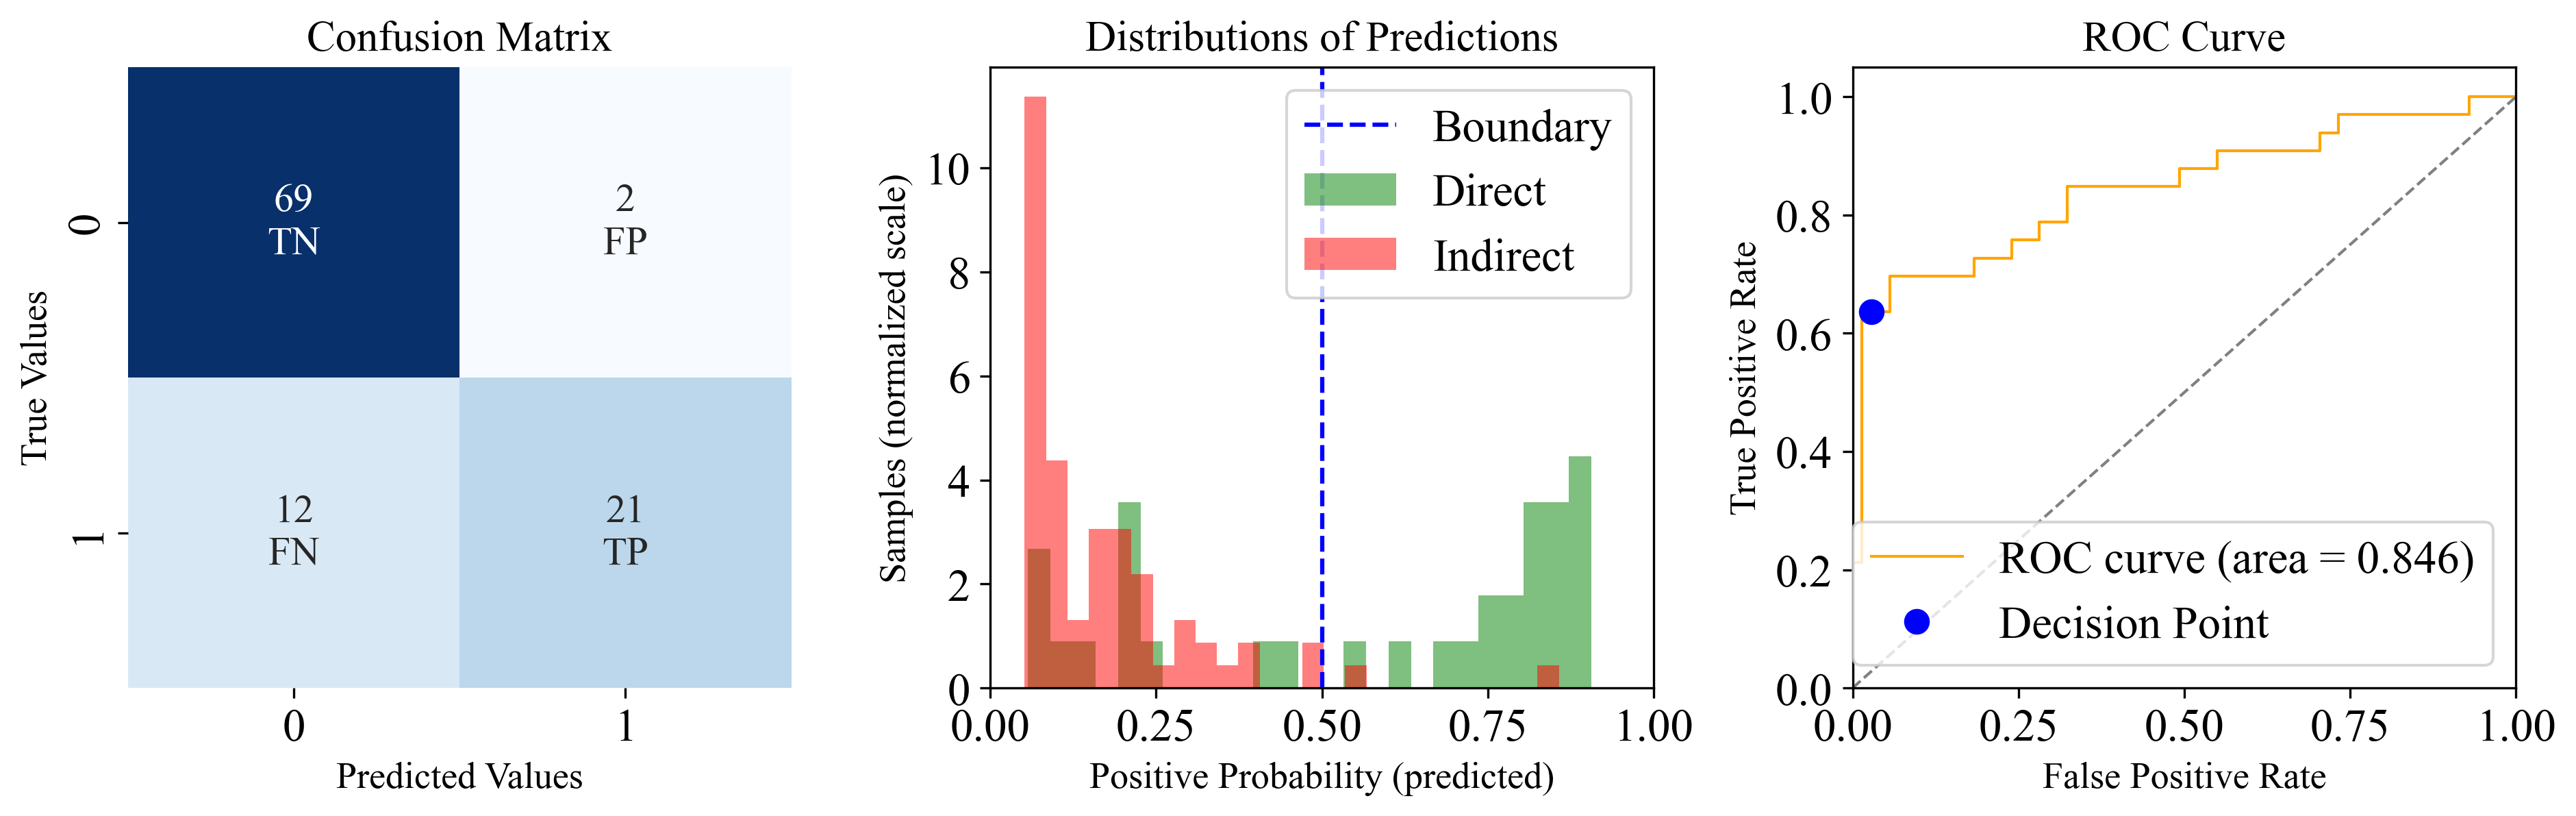

Precision: 0.913 | Recall: 0.636 | F1 Score: 0.75 | AUC: 0.846


{'Precision': 0.9130434782608695,
 'Recall': 0.6363636363636364,
 'F1 Score': 0.75,
 'AUC': 0.8463508322663252}

In [27]:
y_prob = model.predict_proba(X_test.values)
print(accuracy_score(y_test,y_pred),f1_score(y_test,y_pred))
print(0.5*accuracy_score(y_test,y_pred)+0.5*f1_score(y_test,y_pred))
binary_performances(y_test,y_prob)

In [29]:
test_data = pd.DataFrame({'formula':['Na2MoSe4','ZnLu2S4','BeLu2S4'],'$y$':[1,1,1]})
test_data = Featurizor().featurize(test_data,is_structure=False,is_new_data=True)
def get_f(data):
        f = data['$Ve_b$']-data['$F_b$']+data['$Ns_a$']-data['$Nd_b$']
        return f
test_data['0'] = get_f(test_data)
test_data = test_data[X_train.columns]
test_data

MultipleFeaturizer:   0%|          | 0/3 [00:00<?, ?it/s]

,$Dp_b$,$F_b$,LUMO_character,$R_b$,$D_b$,$Nd_b$,$Ce_a$,LUMO_element,$Fi_b$,$(En)diff_{ab}$,$(En)diff_{cb}$,$o$,0
0,162.7,1,3,1.02,0.971,0,6.82,42,495.8,1.23,1.62,0.515152,1
1,137.0,3,1,0.86,9.840,1,1.35,30,523.5,0.38,1.31,0.467391,1
2,137.0,3,1,0.86,9.840,1,3.32,4,523.5,0.30,1.31,0.467391,1


In [30]:
for model,name in zip(classifiers+[model],names+['Committee']):
    model.fit(X_train.values,y_train.values)
    print(name,model.predict(test_data.values))

Random Forest [1 1 1]
LGBM [1 1 1]
Logistic Regression [1 1 1]
ExtraTrees [1 1 1]
XGBoost [1 1 1]
